<a href="https://colab.research.google.com/github/parthasarathydNU/gen-ai-coursework/blob/main/advanced-llms/CourseWork/INFO_7374_Lecture_4_Instruction_Tuning_PEFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch import optim

In [ ]:
!pip install -q -U bitsandbytes wandb datasets sentence_transformers faiss-gpu
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U git+https://github.com/huggingface/trl.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparin

# Bytepair Encoding

Tokenizers used by Llama models and OpenAI's ChatGPT and GPT-4 do not use character level tokenizers, instead the tokens are learned using the bytepair encoding algorithm.

A tokenizer may not be suitable if it has been trained on text that is different from the one you will use to train a model from scratch

for example:
* new language
* new characters
* new domain


Training a tokenizer is different from training a model. A model uses gradient descent. Training a tokenizer is a statistical process that tries to identify which subwords are best to pick for a given corpus, and the way the subwords are chosen depend on the tokenization algorith. It is deterministic.


Byte Pair Encoding (BPE) works by iteratively merging the most frequent pair of adjacent symbols (bytes or characters) in a text dataset to form new symbols. This process continues until a specified vocabulary size is reached, effectively encoding more frequent sequences as single units and reducing the overall number of tokens needed to represent the text

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

corpus = [
    "The sun shines brightly.",
    "Cats love to sleep.",
    "Python is a versatile language.",
    "Music brings joy.",
    "The ocean is vast and deep.",
    "Books are windows to the world.",
    "Space exploration inspires imagination.",
    "Art transcends boundaries.",
    "Technology advances rapidly.",
    "Dreams fuel progress."
]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Next, we need to pre tokenize that corpus into words.

The character Ġ is used in place of a space. This is way to tell the model taht it is the beginning of a new word. Note that we do not add it to beginning of a sentence, because often there is a `<S>` or `<bos>` start token so additionally adding Ġ would be unnecessary.

In [ ]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(corpus[0])

[('The', (0, 3)),
 ('Ġsun', (3, 7)),
 ('Ġshines', (7, 14)),
 ('Ġbrightly', (14, 23)),
 ('.', (23, 24))]

Then we compute the frequencies of each word in the corpus as we do the pre tokenization

In [ ]:
from collections import Counter

word_freqs = Counter()

for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    words = [word for word, offset in words_with_offsets]
    word_freqs.update(words)

print(word_freqs)

Compute base vocabulary

In [ ]:
alphabet = list(set(''.join(word_freqs.keys())))
alphabet.sort()
alphabet

vocab = alphabet.copy()

Now we split each word into its individual characters.

In [ ]:
splits = {word: [c for c in word] for word in word_freqs.keys()}
print(splits)

Now we write a function that computes the frequence of each pair.

In [ ]:
def compute_pair_freqs(splits):
    pair_freqs = Counter()
    for word, freq in word_freqs.items():
        split = splits[word]

        if len(split) == 1:
            # cannot merge any further
            continue
        for i in range(1, len(split)):
            pair = (split[i-1], split[i]) # tuple of candidate tokens
            pair_freqs[pair] += freq
    return pair_freqs

In [ ]:
pair_freqs = compute_pair_freqs(splits)

for i, (pair, count) in enumerate(pair_freqs.items()):
    if i == 5:
        break
    print(f"{pair=} {count=}")

Get most frequent pair

In [ ]:
best_pair = None
max_freq = 0

for pair, freq in pair_freqs.items():
    if freq > max_freq:
        max_freq = freq
        best_pair = pair
print(best_pair, max_freq)

Now we need to merge 'i', 'n' -> in

In [ ]:
merges = {("i", "n"): "in"}
vocab.append("in")

def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

then we repeat, until we reach our target vocab size

In [ ]:
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

<!-- # Evaluation -->

<!-- import math

<!-- def perplexity(probabilities):
    """
    Calculate the perplexity of a sequence of probabilities.

    :param probabilities: A list of probabilities of each word in a sequence.
    :return: The perplexity of the sequence.
    """
    # Ensure probabilities are non-zero to avoid log(0)
    probabilities = [max(p, 1e-10) for p in probabilities]

    # Calculate the log probability of the sequence
    log_prob = sum(math.log(p) for p in probabilities)

    # Normalize by the length of the sequence
    avg_log_prob = -log_prob / len(probabilities)

    # Calculate and return perplexity
    return math.exp(avg_log_prob)

# Example usage
probabilities = [0.2, 0.4, 0.1, 0.3]  # Sample probabilities of words in a sequence
perplexity = perplexity(probabilities)
print("Perplexity:", perplexity) -->


# Scaling

One of the most important insights of LLMs is to measure how performance when we keep the algorithm fixed and vary the scale.



## Scaling Laws

https://arxiv.org/pdf/2001.08361.pdf

![](https://i.ibb.co/bs3tjzD/Screenshot-2024-02-01-at-2-32-29-PM.png)

<!-- ![](https://i.ibb.co/T0t6NKq/Screenshot-2024-02-01-at-2-33-06-PM.png) -->

![](https://i.ibb.co/zJHY138/Screenshot-2024-02-01-at-2-33-28-PM.png)

The performance of LLMs on the next-token prediction task is predictable, and is determined by the number of parameters in the network (N) and the amount of text we train on (D) and there are no indications of performance plateaus. As you increase the model size, the perplexity goes down over time. Note how they all continue to go down.


![](https://llama-2.ai/wp-content/uploads/2023/08/Llama-2-Model-Card-1024x685.png)

The next-prediction task performance is well correlated to a lot tasks that we do care about

![](https://i.ibb.co/nmNc1NW/Screenshot-2024-01-25-at-11-25-52-AM.png)

<!-- # Cost

![](https://i.ibb.co/0MpXYTG/Screenshot-2024-02-01-at-7-31-55-AM.png)

![](https://i.ibb.co/RBBgMgT/Screenshot-2024-01-25-at-10-09-37-AM.png) -->


<!-- # Data -->

<!-- ## Internet
[red pajama](https://www.together.ai/blog/redpajama-data-v2)

[refined web](https://arxiv.org/pdf/2306.01116.pdf)


## Phi -- Textbooks are all you need

### Data

Synthetic code exercises:

![](https://i.ibb.co/jbfNg9y/Screenshot-2024-01-25-at-10-54-34-AM.png)

Synthetic code textbooks

![](https://i.ibb.co/6HSC1rP/Screenshot-2024-01-25-at-10-54-28-AM.png)

Filtered open-source

![](https://i.ibb.co/t37zYBh/Screenshot-2024-01-25-at-10-50-24-AM.png)





![](https://i.ibb.co/LnhMQGS/Screenshot-2024-01-25-at-10-49-01-AM.png)

![](https://miro.medium.com/v2/resize:fit:1400/1*wiNeStO5x06iLks7WQWKxw.png)


![](https://miro.medium.com/v2/resize:fit:1400/1*tBr1LW5uee7NyG9QgB3eeQ.png) -->




# Tips For Training Neural Networks

1. Babysitting your loss curves are useful in the beginning to debug, but don't overdo it
2. Spend time on building visualization tools
3. Add tests where you can, models often fail silently. It is important to check what you can. For example, add tests to check that you are applying softmax along the correct dimension.
4. Create small synthetic datasets to iterate/debug quickly
5. Spend a lot time looking at and improving your data.
6. Be paranoid

## Logging experiments with Weights and Biases

In [ ]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 1)

    def forward(self, x):
        return self.lin(x)



In [ ]:
import wandb

lr = 0.001
epochs = 100

run = wandb.init(
    project="info-7374-wandb-demo",
    config={
        "learning_rate": lr,
        "epochs": epochs
    }
)

net = MLP()

x = torch.randn((8, 4)).float()

optimizer = optim.SGD(net.parameters(), lr=lr)

for epoch in range(epochs):
    optimizer.zero_grad()

    pred = net(x)
    loss = ((pred - 3) ** 2).mean()

    loss.backward()
    optimizer.step()

    wandb.log({"loss": loss.item()})



## Train/Test Split

In machine learning, a train/test split is essential for evaluating a model's ability to generalize, which means performing well on new, unseen data. This split helps avoid overfitting, where a model performs well on training data but poorly on new data. The generalization error, measured by the model's performance difference on training and testing sets, indicates how well the model captures underlying patterns without memorizing specific training data.

## Interpreting Loss Curves

Loss curves are graphs that plot the loss function (a measure of model error) against the number of epochs (iterations over the entire dataset) during training.
Typically, there are two curves: one for the training loss and one for the validation loss.

Key Points to Look For:
Convergence: Both training and validation loss should decrease over time and eventually plateau, indicating that the model is learning.

Gap Between Curves: A small gap between training and validation loss suggests good generalization. A large gap implies overfitting (model performs well on training data but poorly on unseen data).


Scenarios and Interpretations:

Ideal Scenario: Both losses decrease and stabilize with a minimal gap, indicating good learning and generalization.


Overfitting: Training loss continues to decrease, but validation loss starts to increase or remains high. The model learns training data specifics, failing to generalize.


Underfitting: Both losses are high or decrease very slowly, suggesting that the model is too simple to capture underlying patterns.

High Variance: If the loss curves are very noisy, it might indicate that the model is sensitive to small fluctuations in the training data, or the learning rate is too high.


Actions Based on Interpretations:
To Address Overfitting: Use regularization techniques, obtain more data, or simplify the model.
To Address Underfitting: Increase model complexity, train for more epochs, or use a better-suited model architecture.


To Reduce High Variance: Lower the learning rate, use batch normalization, or increase the batch size.

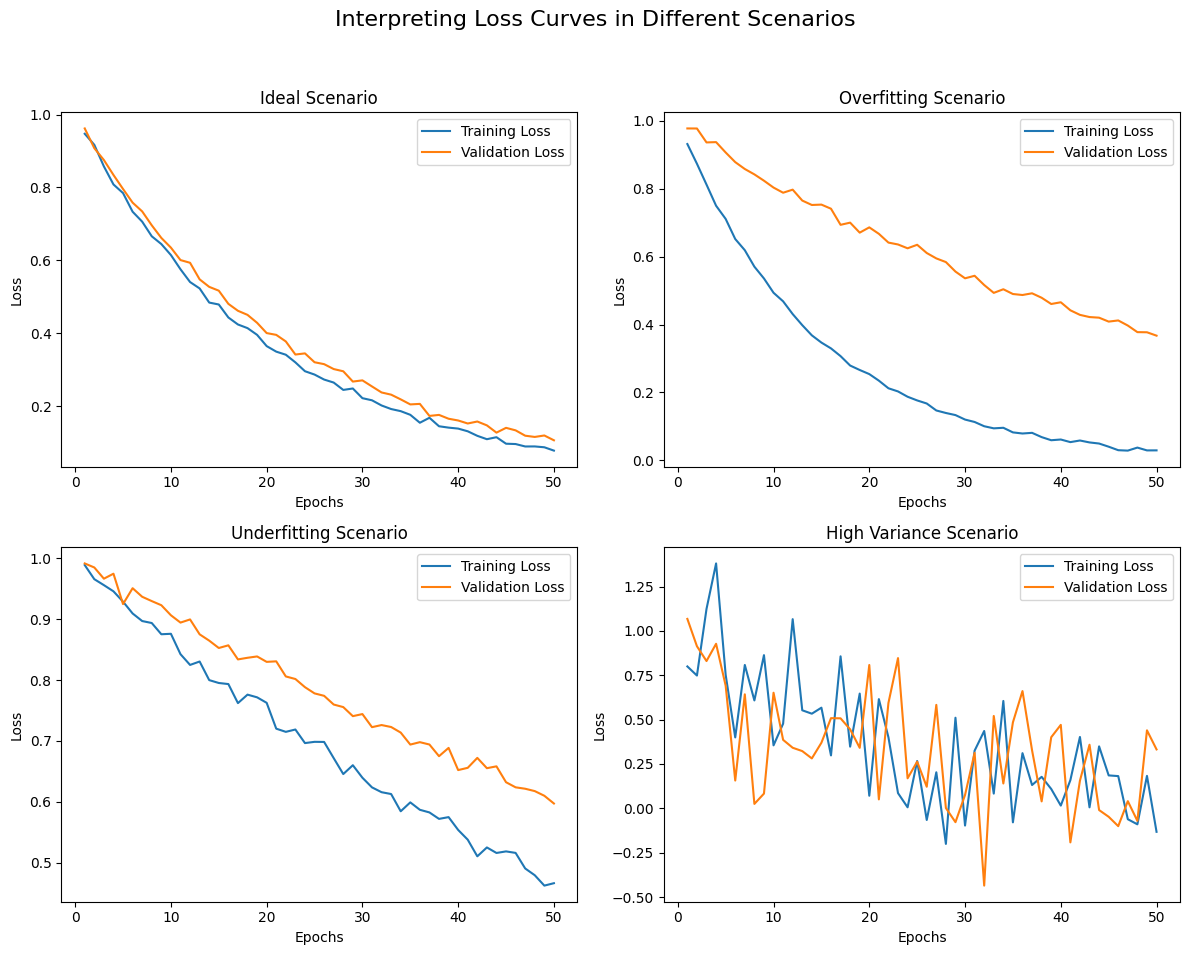

In [ ]:
# Sample epochs
epochs = np.arange(1, 51)

# Generating sample loss values for different scenarios
# Ideal Scenario
ideal_train_loss = np.exp(-0.05 * epochs) + 0.3 * np.random.normal(0, 0.02, len(epochs))
ideal_val_loss = np.exp(-0.045 * epochs) + 0.3 * np.random.normal(0, 0.02, len(epochs))

# Overfitting Scenario
overfit_train_loss = np.exp(-0.07 * epochs) + 0.2 * np.random.normal(0, 0.02, len(epochs))
overfit_val_loss = np.exp(-0.02 * epochs) + 0.5 * np.random.normal(0, 0.02, len(epochs))

# Underfitting Scenario
underfit_train_loss = np.exp(-0.015 * epochs) + 0.5 * np.random.normal(0, 0.02, len(epochs))
underfit_val_loss = np.exp(-0.01 * epochs) + 0.5 * np.random.normal(0, 0.02, len(epochs))

# High Variance Scenario
high_variance_train_loss = np.exp(-0.05 * epochs) + 0.5 * np.random.normal(0, 0.5, len(epochs))
high_variance_val_loss = np.exp(-0.045 * epochs) + 0.5 * np.random.normal(0, 0.5, len(epochs))

# Creating subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Interpreting Loss Curves in Different Scenarios', fontsize=16)

# Ideal Scenario Plot
axes[0, 0].plot(epochs, ideal_train_loss, label='Training Loss')
axes[0, 0].plot(epochs, ideal_val_loss, label='Validation Loss')
axes[0, 0].set_title('Ideal Scenario')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Overfitting Scenario Plot
axes[0, 1].plot(epochs, overfit_train_loss, label='Training Loss')
axes[0, 1].plot(epochs, overfit_val_loss, label='Validation Loss')
axes[0, 1].set_title('Overfitting Scenario')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Underfitting Scenario Plot
axes[1, 0].plot(epochs, underfit_train_loss, label='Training Loss')
axes[1, 0].plot(epochs, underfit_val_loss, label='Validation Loss')
axes[1, 0].set_title('Underfitting Scenario')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# High Variance Scenario Plot
axes[1, 1].plot(epochs, high_variance_train_loss, label='Training Loss')
axes[1, 1].plot(epochs, high_variance_val_loss, label='Validation Loss')
axes[1, 1].set_title('High Variance Scenario')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show plot
plt.show()

## LR Finder

The idea is to start with a very small learning rate, gradually increase it every mini-batch, and record the loss at each step. Typically, the optimal learning rate is found just before the loss starts to increase rapidly.

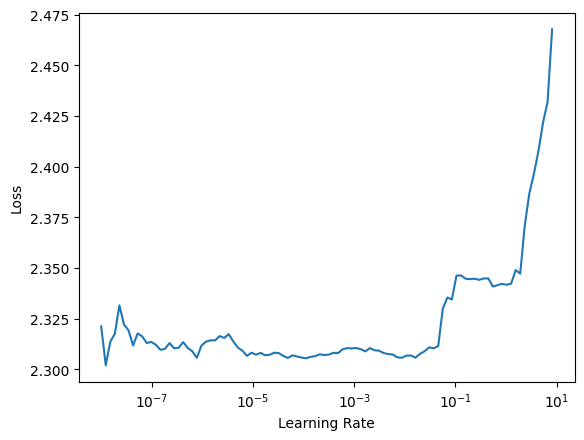

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the MLP Model
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# LR Finder Implementation
def find_lr(model, criterion, optimizer, steps=100, init_value=1e-8, final_value=10., beta=0.98):
    mult = (final_value / init_value) ** (1/steps)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    losses = []
    log_lrs = []
    for batch_num in range(steps):
        # Generate random data for each step
        inputs = torch.randn(10, 784)
        targets = torch.randint(0, 10, (10,))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**(batch_num+1))
        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        # Record the best loss
        if smoothed_loss < best_loss or batch_num == 0:
            best_loss = smoothed_loss
        # Store the values
        losses.append(smoothed_loss)
        log_lrs.append(lr)
        # SGD step
        loss.backward()
        optimizer.step()
        # Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

# Initialize the model, criterion, and optimizer
model = SimpleMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Run the LR Finder
log_lrs, losses = find_lr(model, criterion, optimizer)

# Plot the Results
plt.plot(log_lrs, losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


## LR Scheduler

Learning rate schedulers adjust the learning rate during training. They can help improve performance and stability.

1. StepLR: Decays the learning rate of each parameter group by a factor gamma every step_size epochs.

```
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
```

2. ExponentialLR: Decays the learning rate of each parameter group by gamma every epoch.

```
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
```

3. CosineAnnealingLR: Adjusts the learning rate using a cosine annealing schedule.

```
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
```


To use it:
```
for epoch in range(num_epochs):
    for batch in dataloader:
        train_batch(batch)
        scheduler.step()  # for schedulers like CyclicLR or OneCycleLR

    validate()
    scheduler.step()  # for epoch-based schedulers like StepLR or ReduceLROnPlateau
```



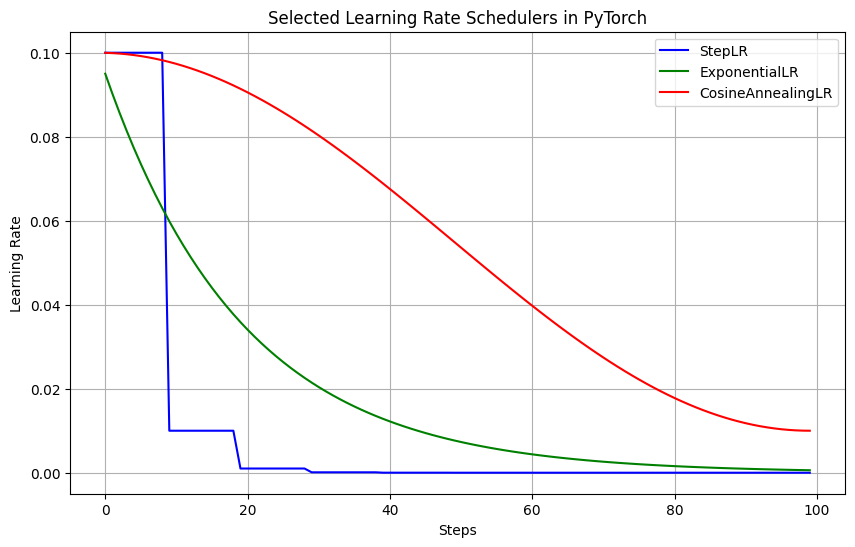

In [ ]:
from torch.optim.lr_scheduler import (
    StepLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau,
    CyclicLR, OneCycleLR
)


# Simulating different LR schedulers in PyTorch
def simulate_scheduler(scheduler, steps=100):
    lrs = []
    for i in range(steps):
        scheduler.step()
        lr = scheduler.optimizer.param_groups[0]['lr']
        lrs.append(lr)
    return lrs

# Redefining the selected LR schedulers with more distinct colors
selected_schedulers = {
    "StepLR": StepLR(torch.optim.SGD([torch.tensor(0.0)], lr=0.1), step_size=10, gamma=0.1),
    "ExponentialLR": ExponentialLR(torch.optim.SGD([torch.tensor(0.0)], lr=0.1), gamma=0.95),
    "CosineAnnealingLR": CosineAnnealingLR(torch.optim.SGD([torch.tensor(0.0)], lr=0.1), T_max=100, eta_min=0.01),
}

# Plotting the selected schedulers with distinct colors
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
for (name, scheduler), color in zip(selected_schedulers.items(), colors):
    lrs = simulate_scheduler(scheduler)
    plt.plot(lrs, label=name, color=color)

plt.title("Selected Learning Rate Schedulers in PyTorch")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.legend()
plt.grid(True)
plt.show()


# Instruction Tuning





We want to optimize models for $P(answer|prompt)$, but they've been trained on $P(next\_token|context)$.

The pretrained model is a document completer (GPT1-3). We need a task that we can run on a lot of data and a lot of compute and we can fine training signals that are cheap to produce. One argument is that if you can predict the next token well, you must have learned some meaningful representation of the world. And this representation of the world is also useful because they can be adapted so that they can do things that are useful for humans.

Pretrained models, often trained as document completers, generate text that is likely to follow the statistical patterns seen in their training data. However, this doesn’t necessarily mean they will adhere to specific instructions given in the prompt.

Instruction tuning is a method to align the model’s behavior with the given instructions. It adapts the model to not just generate text that is contextually relevant, but also follows the specific instructions provided. This is particularly important in applications where the model needs to exhibit certain behaviors or produce outputs in a specific format.

For example, if we want a model to generate a poem in a specific style or a summary of a complex document, simply providing the instruction in the prompt might not be sufficient with a pretrained model. Instruction tuning helps in such cases by explicitly optimizing the model to follow the instructions.

In essence, instruction tuning shifts the model from being a generic document completer to a more controlled text generator that can follow specific instructions, thereby improving its utility in a wide range of applications.

One approach do this is supervised finetuning.


At a high level, this is how we do instruction tuning:
1. Collect a dataset of instruction-response pairs
2. Finetune the pretrained model


## Ideas
* If we train on some fixed number of tasks, our model will become to be proficient at other tasks even though it hasn't seen that particular task during training.
* Reframe problems as prompts


#### Terminology

Novel tasks that were not seen during training. Learning to do new tasks on-the-fly.

Zero shot: Performing a task without any example in the prompt

One shot: Performing a task with a single example in the prompt

Few shot (N-shot): Performing a task $N$ examples in the prompt



## Multitask Prompted Training Enables Zero Shot Task Generalization

https://arxiv.org/pdf/2110.08207.pdf

![](https://i.ibb.co/YRy2k95/Screenshot-2024-01-27-at-2-35-03-PM.png)


## Finetuned Language Models are Zero-Shot Learners
https://arxiv.org/pdf/2110.08207.pdf

![](https://i.ibb.co/hyC1x8S/Screenshot-2024-01-27-at-2-40-05-PM.png)


## Scaling Instruction-Finetuned Language Models
https://arxiv.org/pdf/2210.11416.pdf

![](https://i.ibb.co/RjVQ3Wm/Screenshot-2024-01-27-at-2-43-33-PM.png)



## Supervised Finetuning



# Fine Tuning

1. Pre-Trained Foundation: Language models already have a broad understanding of language and context from their initial training on large datasets.
2. Specific Adaptation: Fine-tuning tailors the model to specific tasks or domains, improving accuracy in those areas.
3. Learning Efficiency: Starting from a pre-trained state requires less data and training time to achieve high performance on specialized tasks.
4. Transfer Learning: Skills learned in pre-training transfer well to a variety of tasks, making the model versatile and effective.

![](https://i.ibb.co/BwZJGP5/Screenshot-2024-01-27-at-4-15-05-PM.png)



Full fine-tuning updates all the parameters in the network and requires the same compute as in the pretraining phase.

One commonly used approach across machine learning is to freeze most of the layers and only apply the gradient update to the last couple layers in the network.

This, however, is still quite computationally expensive. Now, there are a class of finetuning methods called parameter efficient finetuning methods that are more sophisticated but have been shown empirically to approximate the performance of full finetuning approaches with much less compute

## Parameter Efficient Fine Tuning


### Prefix Tuning

https://arxiv.org/abs/2101.00190

The idea in prefix tuning is to add a trainable tensor to each transformer block instead of only the input embeddings, as in soft prompt tuning.

![](https://i.imgur.com/0fArg6F.png)

```
# pseudocode
def transformer_block_with_prefix(x, soft_prompt):
    soft_prompt = FullyConnectedLayers (soft_prompt) # Prefix
    × = concatenate( [soft_prompt, x], dim=seg_ len)
    residual = x
    x = self attention(x)
    x = LaverNorm(x + residual)
    residual = x × = FullyConnectedLayers (x)
    x = LayerNorm(× + residual)
    return x
```



W_delta = [24, 24]  4096 * 4096 params

B = [24, 2] 8 * 4096 params
A = [2, 24] 8 * 4096 params



B @ A = [24, 24] = 16 * 4096 params



### LoRA (Low-rank adaptation)

https://arxiv.org/abs/2106.09685

![lora](https://storage.googleapis.com/lightning-avatars/litpages/01hmchy7r24jjmg7ez52nrm1h1/Screenshot%202024-01-17%20at%203.31.43%E2%80%AFPM.png)

LORA introduces a low-rank decomposition of the weight updates. This means that instead of updating the entire weight matrix in a neural network layer, LORA updates are restricted to a low-rank subspace. This is achieved by decomposing the weight updates into two smaller matrices, which significantly reduces the number of parameters that need to be trained.

At initialization we set the bias = 0 and we sample from a normal distribution with mean 0. The idea is that at initialization the adapter does nothing since everything is 0. This way our initialization is essentially just the base model.


In the original LoRA paper, they introduce a scaling coefficient for applying the LoRA weights to the pretrained weights during the forward pass.

```
scaling = alpha / r
weight += scaling * (lora_B @ lora_A)

```
Rule of thumb is to set `alpha=2*rank`, however it is a hyperparameter that you will need to tune in order to get the best results for your use case

In [ ]:
import torch

BATCH, CHANNELS = 8, 64

X = torch.randn((BATCH, CHANNELS)).float()

weights = torch.randn((CHANNELS, CHANNELS)).float()

X_new = X @ weights

print(X_new.shape)

print(f"Num trainable: {weights.numel()}")

torch.Size([8, 64])
Num trainable: 4096


In [ ]:
# lora
BATCH, CHANNELS = 8, 64

rank = 2
scaling = 0.5

X = torch.randn((BATCH, CHANNELS)).float()
weights = torch.randn((CHANNELS, CHANNELS)).float()

B = torch.randn((CHANNELS, rank)).float()
A = torch.randn((rank, CHANNELS)).float()

frozen = (X @ weights)
trainable = X @ B @ A

X_new = frozen + scaling*trainable

print(X_new.shape)


print(f"Num trainable: {A.numel() + B.numel()}")


torch.Size([8, 64])
Num trainable: 256


#### Merging a LoRA adapter



In [ ]:
import torch
import torch.nn as nn

class LoRALayer(nn.Module):
    def __init__(self, input_dim, output_dim, rank, scale=0.5):
        super(LoRALayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.B = nn.Parameter(torch.randn(output_dim, rank))
        self.A = nn.Parameter(torch.randn(rank, input_dim))
        self.scale = scale

    def forward(self, x):
        lora_adjustment = self.B @ self.A
        return self.linear(x) + scale * (x @ lora_adjustment)

# Example usage
input_dim = 256  # Input dimension
output_dim = 256 # Output dimension
rank = 16       # Rank of LoRA adapter

lora_layer = LoRALayer(input_dim, output_dim, rank)
input_tensor = torch.randn(1, input_dim)  # Example input
output = lora_layer(input_tensor)

print(output.shape)


torch.Size([1, 256])


In [ ]:
# to merge

input_dim = 256
output_dim = 256
scale = 0.5
rank = 16

W = torch.randn((input_dim, output_dim))
B = torch.randn((input_dim, rank))
A = torch.randn((rank, output_dim))

merged_W = W + scale * (B @ A)

#### Lora with Huggingface


[5, 15, 16]
T = 16
[B, T, C]
5 -> 16
15 -> 16
16 no changes

aaaaa[PAD][PAD][PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]   


In [ ]:
from transformers import AutoTokenizer

model_tag = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_tag)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("garage-bAInd/Open-Platypus")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})


In [ ]:
# split dataset into train/test
dataset = dataset.filter(lambda x: x['input'] == '') # only keep samples do not have input field
dataset = dataset.filter(lambda x: len(tokenizer.tokenize(x['instruction'] + x['output'])) < 256) # filter out long sequences
dataset = dataset.remove_columns(['input', 'data_source'])
dataset = dataset['train'].train_test_split(test_size=0.1)
print(dataset)

Filter:   0%|          | 0/19771 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2654 > 2048). Running this sequence through the model will result in indexing errors


DatasetDict({
    train: Dataset({
        features: ['output', 'instruction'],
        num_rows: 7324
    })
    test: Dataset({
        features: ['output', 'instruction'],
        num_rows: 814
    })
})


In [ ]:
print(dataset['train'][0])

{'output': 'Then $BM=1$. Also, $\\angle CMB=\\angle CMA=90^\\circ$. So $CM=\\sqrt{7^2-1^2}=\\sqrt{48}$. So by the Pythagorean theorem, $CD=\\sqrt{CM^2+DM^2}=\\sqrt{48+DM^2}$. We know that $CD=8$. So we have $\\sqrt{48+DM^2}=8$. Then $48+DM^2=64$. So $DM^2=16$. Then $DM=4$. Correct. $BD=3$.\n\n', 'instruction': 'In $\\triangle ABC$, we have $AC=BC=7$  and $AB=2$. Suppose that  $D$ is a point on line $AB$ such that $B$ lies between $A$ and $D$ and $CD=8$. What is  $BD$?'}


In [ ]:
alpaca_prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    outputs      = examples["output"]
    texts = []
    for instruction, output in zip(instructions, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever
        text = alpaca_prompt.format(instruction, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts}

# create text field with formatted prompt + completion + EOS_TOKEN
dataset = dataset.map(formatting_prompts_func, batched=True)

print(dataset['train'][0]['text'])

Map:   0%|          | 0/7324 [00:00<?, ? examples/s]

Map:   0%|          | 0/814 [00:00<?, ? examples/s]

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
In $\triangle ABC$, we have $AC=BC=7$  and $AB=2$. Suppose that  $D$ is a point on line $AB$ such that $B$ lies between $A$ and $D$ and $CD=8$. What is  $BD$?

### Response:
Then $BM=1$. Also, $\angle CMB=\angle CMA=90^\circ$. So $CM=\sqrt{7^2-1^2}=\sqrt{48}$. So by the Pythagorean theorem, $CD=\sqrt{CM^2+DM^2}=\sqrt{48+DM^2}$. We know that $CD=8$. So we have $\sqrt{48+DM^2}=8$. Then $48+DM^2=64$. So $DM^2=16$. Then $DM=4$. Correct. $BD=3$.

<|endoftext|>


In [ ]:
max_length = 256

# [BATCH, TIMESTEPS, FEATURES] # [256, 270 -> 256, 240 -> 256 (add padding tokens) ]

def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        prompt["text"],
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_output = generate_and_tokenize_prompt(dataset['train'][0])

print("Tokenizer eos token id: ", tokenizer.eos_token_id)
print(f"{tokenized_output}")


print(f"keys: {tokenized_output.keys()}")

# print(tokenized_output['input_ids'] != tokenizer.pad_token)
print(tokenized_output['attention_mask'])



Tokenizer eos token id:  50256
{'input_ids': [21106, 318, 281, 12064, 326, 8477, 257, 4876, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 198, 198, 21017, 46486, 25, 198, 818, 39280, 28461, 9248, 9738, 47113, 356, 423, 720, 2246, 28, 2749, 28, 22, 3, 50286, 392, 720, 6242, 28, 17, 35307, 39200, 326, 50286, 3, 35, 3, 318, 257, 966, 319, 1627, 720, 6242, 3, 884, 326, 720, 33, 3, 7363, 1022, 720, 32, 3, 290, 720, 35, 3, 290, 720, 8610, 28, 23, 35307, 1867, 318, 50286, 3, 14529, 3, 30, 198, 198, 21017, 18261, 25, 198, 6423, 720, 12261, 28, 16, 35307, 4418, 11, 39280, 9248, 327, 10744, 28, 59, 9248, 327, 5673, 28, 3829, 61, 59, 21170, 35307, 1406, 720, 24187, 28, 59, 31166, 17034, 90, 22, 61, 17, 12, 16, 61, 17, 92, 28, 59, 31166, 17034, 90, 2780, 92, 35307, 1406, 416, 262, 48657, 363, 29456, 44728, 11, 720, 8610, 28, 59, 31166, 17034, 90, 24187, 61, 17, 10, 23127, 61, 17, 92, 28, 59, 31166, 17034, 90, 2780, 10, 23127, 61, 17, 92, 35307, 775, 760, 326, 720, 8610, 28, 23, 35307, 14

In [ ]:
tokenized_train_dataset = dataset["train"].map(generate_and_tokenize_prompt)
tokenized_test_dataset = dataset["test"].map(generate_and_tokenize_prompt)

Map:   0%|          | 0/7324 [00:00<?, ? examples/s]

Map:   0%|          | 0/814 [00:00<?, ? examples/s]

#### Load in base model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.bfloat16, load_in_8bit=True, device_map="auto")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
!nvidia-smi

Fri Feb  2 07:06:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0              26W /  70W |   3177MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
print(model)

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


In [ ]:
print_trainable_parameters(model)

trainable params: 262364160 || all params: 2779683840 || trainable%: 9.438633136061977


#### Create LoRA Model

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "fc1",
        "fc2",
        "dense",
        "lm_head"
    ],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)


trainable params: 48906240 || all params: 1570298880 || trainable%: 3.114454236890241


In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4

#### Data Collator

Data collators are objects that will form a batch by using a list of dataset elements as input. To be able to build batches, data collators may apply some processing (like padding)

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
from transformers import DataCollatorForLanguageModeling, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained('microsoft/phi-2')
if tokenizer.pad_token == None:
    tokenizer.pad_token = tokenizer.eos_token

# Example text data
texts = ["Hello, this is a test.", "This is another example of a text."]

# Tokenize the texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Initialize the data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Set mlm to False for causal language modeling
)

# Use the data collator to prepare batch
batch = data_collator([inputs])

# The outputs are ready to be used with a model
print(batch)

# Just for demonstration, showing keys and tensor shapes
for key, value in batch.items():
    print(f"{key}: {value.shape}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'input_ids': tensor([[[15496,    11,   428,   318,   257,  1332,    13, 50256],
         [ 1212,   318,  1194,  1672,   286,   257,  2420,    13]]]), 'attention_mask': tensor([[[1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1]]]), 'labels': tensor([[[15496,    11,   428,   318,   257,  1332,    13,  -100],
         [ 1212,   318,  1194,  1672,   286,   257,  2420,    13]]])}
input_ids: torch.Size([1, 2, 8])
attention_mask: torch.Size([1, 2, 8])
labels: torch.Size([1, 2, 8])


In [ ]:
batch

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    lr_scheduler_type='cosine',
    max_steps=50,
    learning_rate=2e-5, # Want a small lr for finetuning
    optim="paged_adamw_8bit",
    logging_steps=5,             # When to start reporting loss
    save_strategy="steps",       # Save the model checkpoint every logging step
    save_steps=25,                # Save checkpoints every 50 steps
    evaluation_strategy="steps", # Evaluate the model every logging step
    eval_steps=10,               # Evaluate and save checkpoints every 50 steps
    do_eval=True,                # Perform evaluation at the end of training
    report_to="wandb",           # Comment this out if you don't want to use weights & biases
)

trainer = Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=training_args,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

trainer.train()

wandb: Currently logged in as: blai88. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

#### Push lora adapter to huggingface hub

In [ ]:
from google.colab import userdata

# Defined in the secrets tab in Google Colab
hf_token = userdata.get('huggingface')

model.push_to_hub("blai2/peft_adapter_demo", token=hf_token)

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:134: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


adapter_model.safetensors:   0%|          | 0.00/454M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/blai2/peft_adapter_demo/commit/94e057e5d65d9a13853fa4193c2798612a59b01b', commit_message='Upload model', commit_description='', oid='94e057e5d65d9a13853fa4193c2798612a59b01b', pr_url=None, pr_revision=None, pr_num=None)

It is sufficient to just save the adapter since it stores the base model

![](https://i.ibb.co/PGCS1Dc/Screenshot-2024-02-01-at-11-16-08-PM.png)

#### Load LoRA model from hub

In [ ]:
from peft import AutoPeftModelForCausalLM

model_from_hub = AutoPeftModelForCausalLM.from_pretrained("blai2/peft_adapter_demo", load_in_4bit=True)

print(model_from_hub)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/454M [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4

In [ ]:
merged_model = model_from_hub.merge_and_unload()

print(merged_model)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:249: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layern

You can similarly push/load the merge model using

```
# push
merged_model.push(model_id)

# load
model = AutoModelForCausalLM(model_id)

```

<!-- ### QLoRA

https://arxiv.org/abs/2305.14314

QLoRA quantizes the pretrained weights to 4-bit precision and uses paged optimizers to handle memory spikes.

Training the peft model, follows the steps steps as above. -->

<!-- ```
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "microsoft/phi-2"

quantization_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, quantization_config=quantization_config, device_map="auto")
``` -->

## Proxy Tuning
https://arxiv.org/abs/2401.08565



Lightweight decoding time algorithm that operates on top of black box LMs to achieve the result of directly tuning the model, but by accessing only its prediction over the output vocabulary.

Tunes a smaller LM, then applies the difference between the predictions of the smaller tuned and untuned LMs to shift the original predictions of the based model in the direction of tuning, while retaining the benefits of larger scale pretraining

![](https://i.imgur.com/Xtudenz.png)


 Tune a smaller open model instead (possibly available off-the-shelf), then apply the logit difference between small tuned & untuned models to logits of the original model, effectively shifting them in the direction of tuning while retaining benefits of larger scale.

 In fact, proxy-instruction-tuned models are *more truthful* than directly-tuned models on TruthfulQA, suggesting decoding-time tuning may better preserve learned knowledge


 ```
 generated_tokens = []

input_txt = (
  "If I have 5 apples and eat 2, but then find 3 more"
  " on my way home, how many do I have?"
)
input_ids = tokenizer.encode(input_text)

for _ in range(max_length):
    # Obtain logits
    logits_base = model_base(input_ids).logits # Llama 7B Base
    logits_tuned = model_tuned(input_ids).logits # Llama 7B Chat
    logits_target = model_target(input_ids).logits # Llama 70B Base
                               
    # Apply proxy-tuning                            
    logits = (
        logits_target + (logits_tuned - logits_base)
    )

    # Normalize logits and obtain token
    predictions = torch.softmax(logits[:, -1, :], dim=-1)
    next_token_id = torch.argmax(predictions).unsqueeze(0)
    generated_tokens.append(next_token_id.item())
    
generated_text = tokenizer.decode(generated_tokens)
print(generated_text)
```

# Instruction Data

High-quality data is fundamental to produce a good model. The higher the quality, the better the model.

You can find your token at this address: https://huggingface.co/settings/tokens and copy paste it in the "Secrets" tab in Google Colab (name: "huggingface").

In [ ]:
from google.colab import userdata

# Defined in the secrets tab in Google Colab
hf_token = userdata.get('huggingface')

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("garage-bAInd/Open-Platypus")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [ ]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Token indices sequence length is longer than the specified maximum sequence length for this model (2281 > 2048). Running this sequence through the model will result in indexing errors


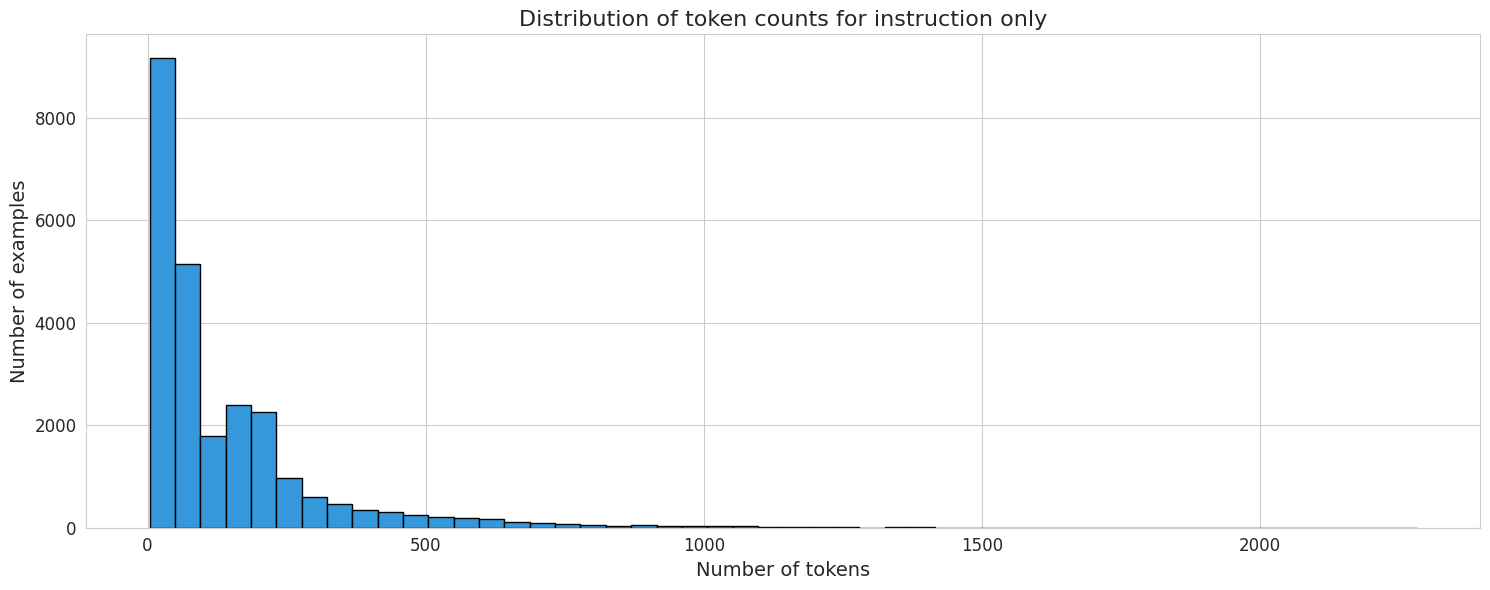

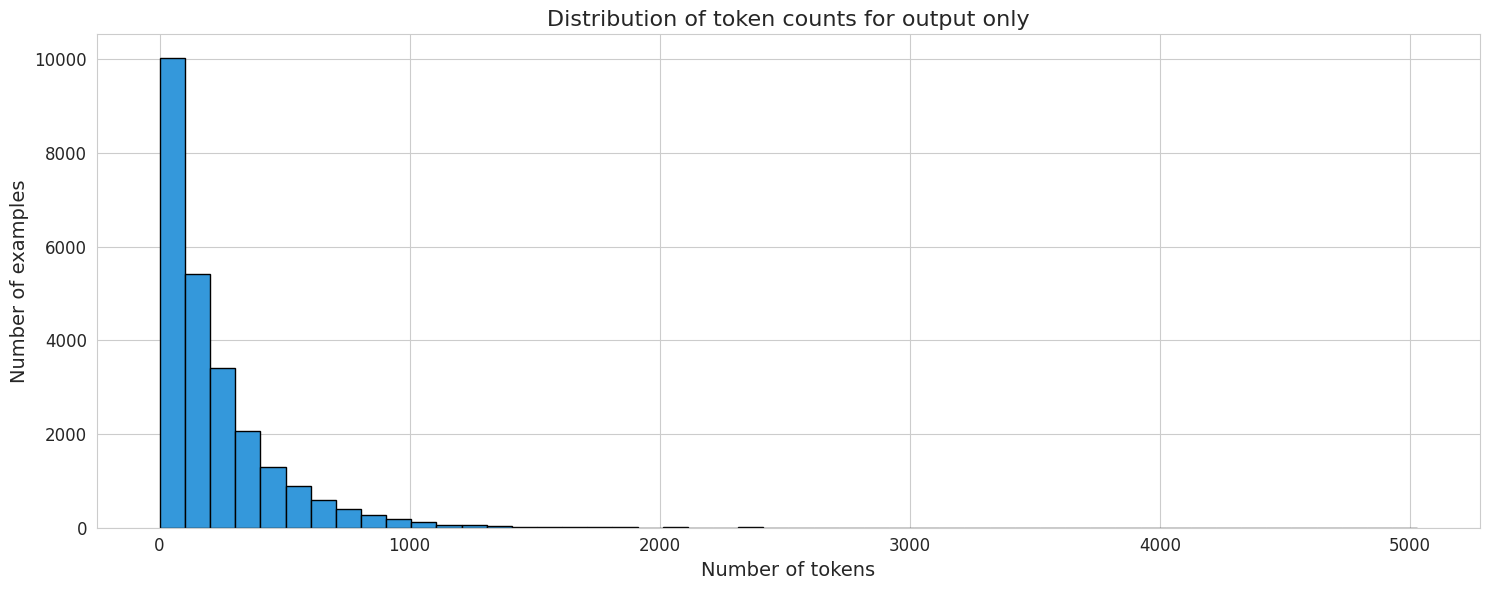

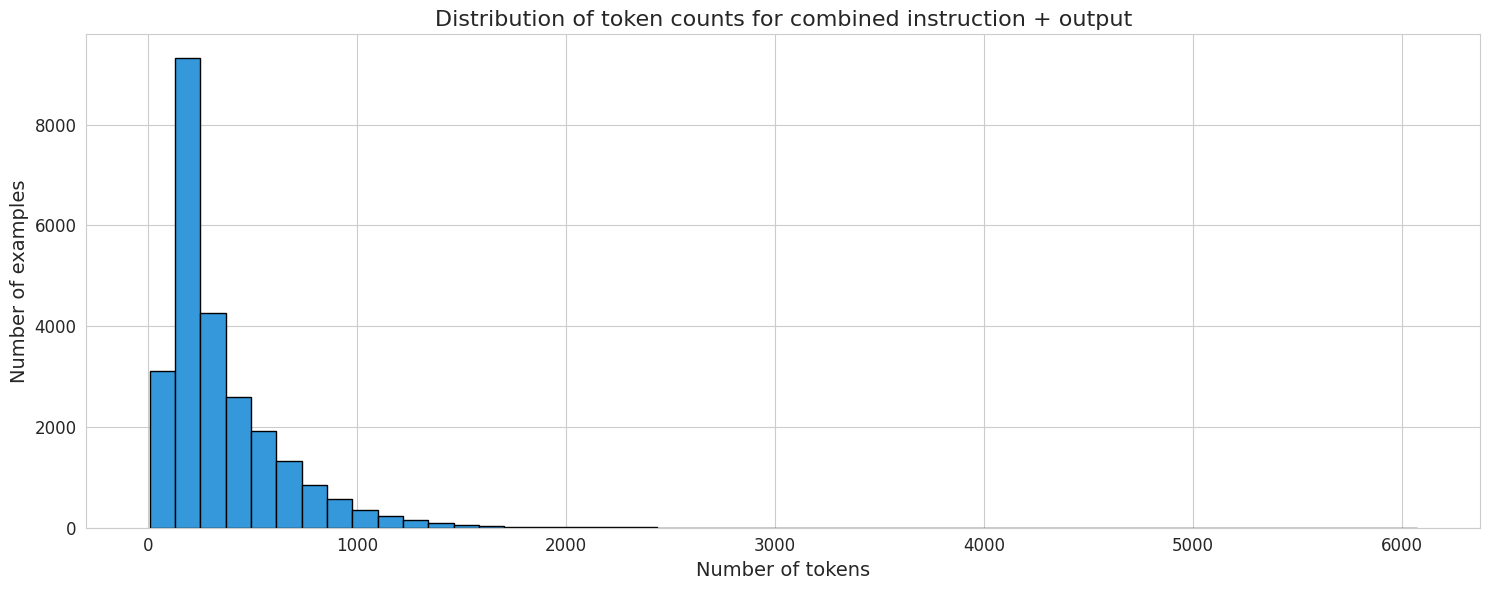

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")

# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

## Filter

### Filter out samples with more than 2048 tokens

Number of valid rows: 24890
Removing 36 rows...


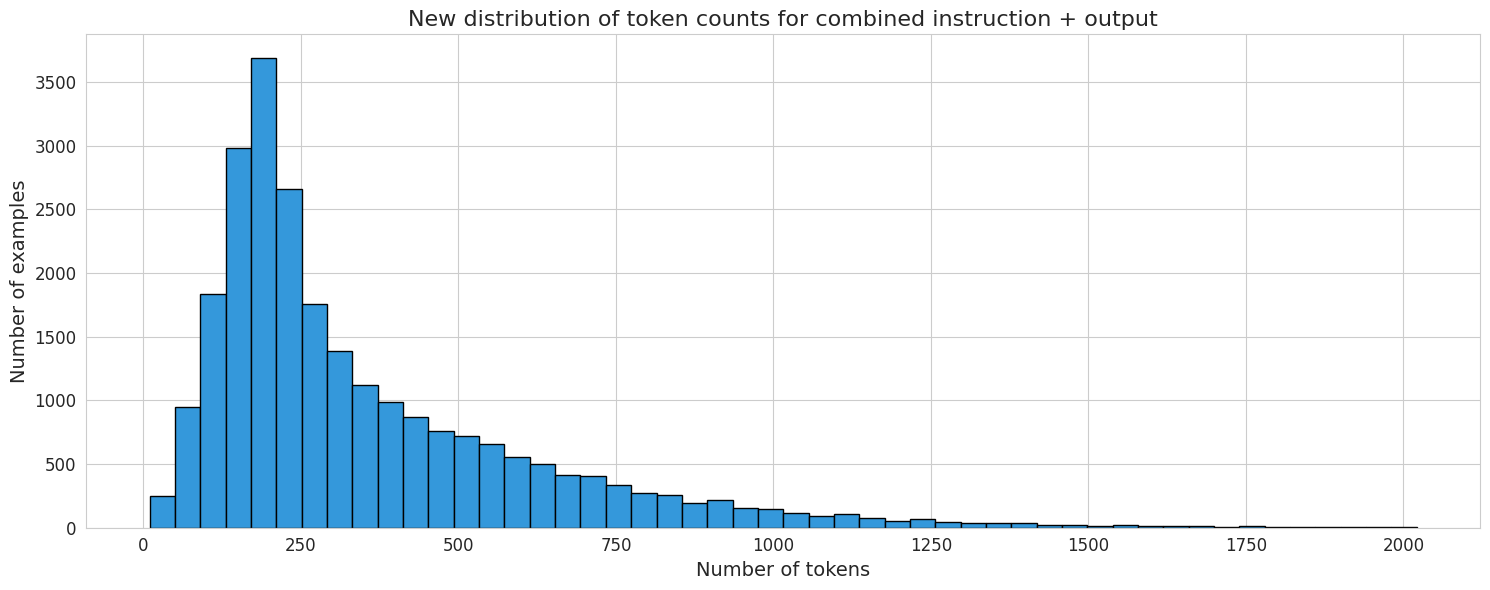

In [ ]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

[batch_size, sequence_len/block_size, channels]

['a']

['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa']

['a[P][P][P][P][P][P][P][P][P][P][P]'] -> embed

['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa']




<!-- ### Filter Out Near-deduplication using embeddings

How to choose the embedding model? Check the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard). In this example, we're not using the best embedding model because it would take too long.

![](https://i.imgur.com/Fbx1Ivz.png) -->

<!-- ```
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["output"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)
```

print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")
-->

## Chat templates

We need to define a **chat template**, which formats the instructions and responses in a way that is suitable for the model. Here's an example of raw instructions and responses from a [Hugging Face blog post](https://huggingface.co/blog/chat-templates):

```
[
    {"role": "user", "content": "Hi there!"},
    {"role": "assistant", "content": "Nice to meet you!"}
]
```

There are different ways to format it. The most straightforward one would be:

```
User: Hey there!
Assistant: Nice to meet you!
```

In the case of Llama 2, the authors used the following template for the **chat models**:

```
<s>[INST] <<SYS>>
System prompt
<</SYS>>

User prompt [/INST] Model answer </s>
```

The impact of chat templates on the performance of the model is unclear. In most cases, we fine-tune base models that have not been trained with a particular template, which is also why there's no clear standard. However, they are important as they can cause many issues and limit the compatibility of your models.

In [ ]:
def chat_template(example):
    example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

Map:   0%|          | 0/24890 [00:00<?, ? examples/s]

## Push to Huggingface Hub

In [ ]:
dataset.push_to_hub("blai2/mini-platypus", token=hf_token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/blai2/mini-platypus/commit/714f07e181fef5a32454b906f83ed643cfe453d1', commit_message='Upload dataset', commit_description='', oid='714f07e181fef5a32454b906f83ed643cfe453d1', pr_url=None, pr_revision=None, pr_num=None)

## Human Labelled Data

### Dolly

### OpenAssistant

### LIMA: Less is More For Alignment

https://arxiv.org/abs/2305.11206

model fine-tuned with the standard supervised loss on only 1,000 carefully curated prompts and responses

![](https://i.ibb.co/DWsdYQb/Screenshot-2024-01-27-at-4-02-10-PM.png)





## Alpaca


Started with the 175 human-written instruction-output pairs from the self-instruct seed set. Then, prompted text-davinci-003 to generate more instructions using the seed set as in-context examples.


![](https://i.imgur.com/vh5lhxp.png)

## WizardLM

https://arxiv.org/pdf/2304.12244.pdf

![](https://i.ibb.co/Krjst22/Screenshot-2024-01-27-at-1-55-19-PM.png)


```
client = OpenAI(os.getenv("OPENAI_API_KEY"))
prompter = Prompter("./prompts")

topics = [args.seed]
prompt_names = [
    "breadth",
    "concretizing",
    "constraint",
    "depth",
    "question_000",
    "question_001",
]

for _ in range(args.rounds):
    initial_topic = random.choice(topics)
    
    for prompt_name in prompt_names:
        prompt = prompter.format(
            prompt_name, {"initial_topic": initial_topic, "count": args.batch_size}
        )
        
        res = completion_with_backoff(
            client, prompt=prompt, model="gpt-3.5-turbo-instruct", max_tokens=256
        )
        
        try:
            generated_topics = parse_output(res.choices[0].text)
            topics.extend(generated_topics)
        except Exception as e:
            print(e)
            continue
```


### Prompt example

Create several new topics by replacing general concepts with more specific concept of the initial topic. The length and complexity of the created topics should be similar to that of the initial topic. Make sure each topic is concise.

Initial topic: {initial_topic}

Write {count} new topics.


## Alpagasus

https://arxiv.org/abs/2307.08701

Use ChatGPT to select only 9k high-quality data from Alpaca's 52k data, leading to faster training, better performance

![](https://i.ibb.co/xjwxJLG/Screenshot-2024-01-27-at-1-50-28-PM.png)

## Humpback

https://arxiv.org/pdf/2308.06259.pdf
![](https://i.ibb.co/chj4gLG/Screenshot-2024-01-27-at-2-01-57-PM.png)


Start from a base pretrained LM (ie LLAMA), a small amount of seed examples of (instruction, output) pairs, and a collection of unlabelled documents which are considered cnadidate outputs for unknonw instructions.

1. Self-augmentation: the based model is finetuned with (output, instruction) from the seed examples as an instruction prediction model $M_{yx}$, which is used to generate candidate instructions for ouptuts from unlabelled data.

2. Self-curation: starting from an intermediate instruction following model $M_0$ finetuned from seed examples only, it selected high quality (instruction, output) pairsfrom the candidates from the candidates from the previous step, and uses tehn as finetuning data for the next intermediate model $M1$, which is in turn used to select training data for obtinaing $M_2$




## Teaching Small Language Models to Reason

https://arxiv.org/pdf/2212.08410.pdf

![](https://i.ibb.co/3YK4v4r/Screenshot-2024-01-27-at-2-10-34-PM.png)

# Evaluation

LLM evaluation is hard

## Alpaca-Eval
![](https://i.ibb.co/qm0P1M7/Screenshot-2024-01-27-at-4-10-42-PM.png)

## Chatbot Arena

![](https://i.imgur.com/VvdfKAO.png)

![](https://i.imgur.com/qE1Dx47.png)


## Pretraining on the Test Set is All You Need
https://arxiv.org/pdf/2309.08632.pdf



